# <center> Word2vec for Semantic Representation of Words</center>
### <center> CS918 Natural Language Processing </center>

###### <center> Bo Wang </center>
<h6><center> February 2017 </center></h6>
<br/>
<center><img src="images/786px-Warwick_Crest.png" width="90"></center>

>## "You shall know a word by the company it keeps" <br><br>
<center>- Firth, J. R. (1957:11)</center>

## Recap

* Word embeddings allow to represent words in a high dimensional vector space in a way that the spatial relationships between these embeddings represent the relationships between words (share latent features). <br><br>

 * Dimensionality of the space is not that high, typically a few 100 dimensions.
   * Each dimension has some semantic meaning.
 * Word embeddings is a language modeling method, more precisely a distributed vector representation of words.


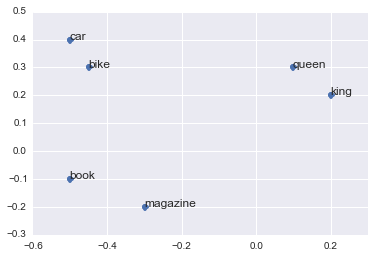

In [2]:
%matplotlib inline

import seaborn as sb
import numpy as np

words = ['queen', 'book', 'king', 'magazine', 'car', 'bike']
vectors = np.array([[0.1,   0.3],  # queen
                    [-0.5, -0.1],  # book
                    [0.2,   0.2],  # king
                    [-0.3, -0.2],  # magazine
                    [-0.5,  0.4],  # car
                    [-0.45, 0.3]]) # bike

sb.plt.plot(vectors[:,0], vectors[:,1], 'o')
sb.plt.xlim(-0.6, 0.3)
sb.plt.ylim(-0.3, 0.5)
for word, x, y in zip(words, vectors[:,0], vectors[:,1]):
    sb.plt.annotate(word, (x, y), size=12)

* Compared to Bag of words: <br><br>

 * Dimensionality is low, and constant wrt the vocabulary size.
 * Word embeddings captures the semantic and syntactic similarities between words.
 

* Compared to topic modeling: <br><br>

 * Better granularity, the base element is a word.
 * We can capture far more diverse semantic meanings without having to build a labeled training text.
 * Great for feature generation for ML models.
 * Though LDA is great for tagging.

* What are word embeddings models good at: <br><br>

 * Modeling similarity between words
         sim(tomato, beefsteak) < sim(apple, tomato) < sim(pear, apple)
    
 * Allows algebric operations on word vectors 
         v(Paris) - v(France) ~= v(Berlin) - v(Germany)

* There are two recently-developed techniques that, by processing free-form text, produce high quality vector representations of words: <br><br>
 * word2vec, a iteration-based method.
     * Introduced in a [2013 paper](http://arxiv.org/pdf/1301.3781.pdf) by Mikolov et al.
     * Accompanied by a [C package](https://code.google.com/archive/p/word2vec/) <br><br>
 * GloVe, a count-based method.
     * Introduced in [an EMNLP 2014 paper](http://www-nlp.stanford.edu/pubs/glove.pdf) by Pennington et al.
     * Code available [here](http://nlp.stanford.edu/projects/glove/)

In [1]:
# Word2vec
from IPython.display import IFrame
IFrame('https://player.vimeo.com/video/112168934', width=800, height=600)


# Gensim

* An open-source vector space modeling and topic modeling toolkit (Python).
    * Homepage: http://radimrehurek.com/gensim/
    * Github: https://github.com/piskvorky/gensim/
    * LGPL: http://www.gnu.org/licenses/lgpl.html

<center><img src="images/gensim-commits.png" width="1000"></center>

### Features

* tf-idf
* LSA
* LDA
* Text Summarization
* **Word2vec** and Doc2vec
* etc

<br><br>
* Parallel (multi-threaded) processing.

### Preparing the Input

* Gensim's word2vec expects a sequence of sentences as its input
    * Each sentence a list of words (utf-8 strings).
    
>```python
import gensim
sentences = [['first', 'sentence'], ['second', 'sentence']]
# train word2vec on the two sentences 
model = gensim.models.Word2Vec(sentences, min_count=1)
```

* Using built-in list is convenient, but can use up a lot of RAM when the input is large.

### Preparing the Input
###### A memory-friendly iterator

* No need to keep everything in RAM: we can provide one sentence, process it, forget it, load another sentence...
<br><br>

```python
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in open(os.path.join(self.dirname, fname)):
                yield line.split() # yield gives you a generator
 
sentences = MySentences('/some/directory') # a memory-friendly iterator
model = gensim.models.Word2Vec(sentences)
```

<br><br>
* Any preprocessing can be done inside the MySentences iterator.

### Preparing the Input
###### word2phrases

* Vector for representing 'san francisco'?
* Check out `gensim.models.phrases`
    * Automatically detect common phrases (multiword expressions) from a stream of sentences.
    * The phrases are collocations (frequently co-occurring tokens).

In [ ]:
from gensim.models.phrases import Phrases
import cPickle as pickle

with open('.../tokenized_tweets.pkl','rb') as fp:
    data=pickle.load(fp)
bigram = Phrases(data, min_count=5, threshold=10.0)
trigram = Phrases(bigram[data], min_count=5, threshold=7.0)
fourgram = Phrases(trigram[bigram[data]], min_count=5, threshold=6.0)
fivegram = Phrases(fourgram[trigram[bigram[data]]], min_count=5, threshold=5.0)

### Preparing the Input
###### word2phrases

* The parameter `threshold` represents a threshold for forming the phrases (higher means fewer phrases). A phrase of words a and b is accepted if $(count(a, b) - min\_count) * N / (count(a) * count(b)) > threshold$, where $N$ is the total vocabulary size.

>```python
>>> sent = [u'the', u'mayor', u'of', u'new', u'york', u'was', u'there']
>>> print(bigram[sent])
[u'the', u'mayor', u'of', u'new_york', u'was', u'there']
```

### Training

* `gensim.models.word2vec` is optimised using Cython. 24x faster.
* Training a model is as simple as it can get in Gensim.

### Training
###### Settings

* Architecture: skip-gram (slower, better for infrequent words) vs CBOW (fast)
* The training algorithm: hierarchical softmax (better for infrequent words) vs negative sampling (better for frequent words, better with low dimensional vectors)
* Sub-sampling of frequent words: can improve both accuracy and speed for large data sets (useful values are in range 1e-3 to 1e-5)
* Dimensionality of the word vectors: usually more is better, but not always
* Context (window) size: for skip-gram usually around 10, for CBOW around 5
* The workers parameter (need Cython) is for training parallelization, to speed up training. 

In [ ]:
from gensim.models.phrases import Phrases
from gensim.models.word2vec import Word2Vec

# Preprocessing your data

# Generate phrases if you wish so, using gensim.models.phrases

# Training:
model = Word2Vec(fivegram[data], sg = 1, size = 300, window = 5, workers = 4, hs = 1, min_count = 5, sample = 1e-3)
## Save in a format compatible with the original word2vec implementation:
model.save_word2vec_format('../word_embedding.model.txt')
## Trim unneeded model memory
## You cannot continue training after doing a replace:
model.init_sims(replace=True)

### Training
###### Resuming training

* Can load a model and continue training it with more sentences:
>```python
model = gensim.models.Word2Vec.load('/tmp/mymodel')
model.train(more_sentences)
```
* ~~However, the vocabulary remains limited to that discovered during the initial scan. Out-of-vocabulary words are ignored.~~
    * ~~Work in process.~~
* Gensim 0.13.3 (2016-10-20) has added vocabulary expansion feature to word2vec, aka online word2vec.
>```python
model.build_vocab(new_sentences, update=True)
model.train(more_sentences)
```

* Not possible to resume training with models generated by the C tool, i.e. `load_word2vec_format()`

### Training
###### Memory and speed

* Gensim word2vec implementation specifics:
     * Training time ~ 8hours on a 8 proc/8 threads to learn 600 dimensions on a 1.9B words corpus
     * Memory requirements depends on the vocabulary size and on the number of dimensions:
            3 matrices * 4 bytes (float) * |dimensions| * |vocabulary|
     * E.g. if your training data contains 100,000 unique words, and you asked for layer size=200, the model will require approx. 100,000\*200\*4\*3 bytes = ~229MB


* The [GloVe implementation in Python](https://github.com/maciejkula/glove-python) takes half the time but has a quadratic memory size. Check pull requests for memory optimizations.

### Evaluation

* Evaluation depends on your end application.
* Google have released their testing set of about 20,000 syntactic and semantic test examples, following the "A is to B as C is to D" task: http://word2vec.googlecode.com/svn/trunk/questions-words.txt
<br><br>
```python
>>> model.accuracy('/tmp/questions-words.txt')
2014-02-01 22:14:28,387 : INFO : family: 88.9% (304/342)
2014-02-01 22:29:24,006 : INFO : gram1-adjective-to-adverb: 32.4% (263/812)
2014-02-01 22:36:26,528 : INFO : gram2-opposite: 50.3% (191/380)
2014-02-01 23:00:52,406 : INFO : gram3-comparative: 91.7% (1222/1332)
2014-02-01 23:13:48,243 : INFO : gram4-superlative: 87.9% (617/702)
2014-02-01 23:29:52,268 : INFO : gram5-present-participle: 79.4% (691/870)
2014-02-01 23:57:04,965 : INFO : gram7-past-tense: 67.1% (995/1482)
2014-02-02 00:15:18,525 : INFO : gram8-plural: 89.6% (889/992)
2014-02-02 00:28:18,140 : INFO : gram9-plural-verbs: 68.7% (482/702)
2014-02-02 00:28:18,140 : INFO : total: 74.3% (5654/7614)
```
<br><br>
* Again it's always best to evaluate directly on your intended task.
     * _"Do I get a significant better classification performance after adding the word vector features?"_

### Storing and loading models

* Standard Gensim methods:

>```python
model.save('/tmp/mymodel')
new_model = gensim.models.Word2Vec.load('/tmp/mymodel')
```

  which uses pickle internally, optionally mmap'ing the model's internal large NumPy matrices into virtual memory directly from disk files, for inter-process memory sharing.
  

* You can also:
    * Save in a format compatible with the original word2vec implementation.
    * Load models created by the original C tool, both using its text and binary formats:

>```python    
model = Word2Vec.load_word2vec_format('/tmp/vectors.txt', binary=False)
# using gzipped/bz2 input works too, no need to unzip:
model = Word2Vec.load_word2vec_format('/tmp/vectors.bin.gz', binary=True)
```

### Using the model
###### Similarities

* Word2vec supports several word similarity tasks out of the box:
<br><br>

```python
>>> model.most_similar(positive=['woman', 'king'], negative=['man'])
[('queen', 0.50882536), ...]

>>> model.most_similar_cosmul(positive=['baghdad', 'england'], negative=['london'])
[(u'iraq', 0.8488819003105164), ...]

>>> model.doesnt_match("breakfast cereal dinner lunch".split())
'cereal'

>>> model.similarity('woman', 'man')
0.73723527

>>> model['computer']  # raw numpy vector of a word
array([-0.00449447, -0.00310097,  0.02421786, ...], dtype=float32)
```

* `most_similar` computes the cosine similarity between word vectors, while `most_similar_cosmul` proposed by [Omer Levy and Yoav Goldberg in 2014](http://www.cs.bgu.ac.il/~yoavg/publications/conll2014analogies.pdf) is less susceptible to one large distance dominating the calculation thus amplifies the differences between small quantities.

In [4]:
### Using the model
###### Similarities
%matplotlib inline

from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import numpy as np
import bokeh
from bokeh.charts import Scatter, output_notebook, show
from bokeh.plotting import figure, show, output_file

model = Word2Vec.load_word2vec_format('/Users/bowang/Dropbox/fivegram_embedding_model.txt', binary=False)
tsne = TSNE(n_components=2, random_state=0)
party_leaders=['miliband','clegg','bennett','sturgeon','farage','cameron']
leader_vec=[]
#Create a list of vectors for party leaders
for p in party_leaders:
    leader_vec.append(model[p])
leader_vec=np.asarray(leader_vec)
#Mapping it to 2D space
leader_vec=tsne.fit_transform(leader_vec)

p=figure(title="Who are these people?")
output_notebook()
p.circle(leader_vec[:,0],leader_vec[:,1])
for party_leader, x, y in zip(party_leaders, leader_vec[:,0], leader_vec[:,1]):
    p.text([x],[y],text=[party_leader])

Loading BokehJS ...

In [5]:
show(p)

In [12]:
### Using the model
###### Clustering
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans
import numpy as np
import time

model = Word2Vec.load_word2vec_format('/Users/bowang/Downloads/GoogleNews-vectors-negative300.bin', binary=True)
#We want cluster 'britain' related 300 terms
words = [i[0] for i in model.most_similar_cosmul('britain',topn=300)]
word_vectors = [model[w] for w in words]
word_vectors=np.asarray(word_vectors)

start = time.time()
num_clusters = 60
#Initalize k-means to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )
end = time.time()
elapsed = end - start
print "Time taken for K Means clustering: ", elapsed, "seconds."

#Create a {word: cluster no.} dictionary.
word_centroid_map = dict(zip( words, idx ))
#Print 10 terms in the first 10 clusters
for cluster in xrange(0,10): 
    print "\nCluster %d" % cluster
    words = []
    for i in xrange(0,len(word_centroid_map.values())):
        if( word_centroid_map.values()[i] == cluster ):
            words.append(word_centroid_map.keys()[i])
    print words[:10]

Time taken for K Means clustering:  0.256619930267 seconds.


In [13]:
#Result:


Cluster 0
[u'hollywood']

Cluster 1
[u'greece', u'cubans', u'malta', u'northern_ireland']

Cluster 2
[u'naija', u'nigerians', u'nigerian', u'jos', u'zim', u'hausa', u'kenya']

Cluster 3
[u'lewis', u'mcdonald', u'thompson', u'pearson', u'christopher', u'alexander', u'alex', u'arthur', u'marcus', u'hansen']

Cluster 4
[u'newcastle', u'burnley', u'blackpool', u'wembley', u'cardiff', u'charlton', u'wigan', u'portsmouth', u'fulham', u'bolton']

Cluster 5
[u'NuLabour', u'EUSSR', u'lib_dems', u'tories', u'Maggie_Thatcher']

Cluster 6
[u'serbs', u'serbia', u'putin', u'russians', u'germans']

Cluster 7
[u'caroline', u'julia', u'laura', u'victoria', u'murdoch', u'sarah', u'sharon', u'darren', u'mr', u'westminster']

Cluster 8
[u'shyt']

Cluster 9
[u'arab', u'israeli', u'syria', u'israel', u'lebanon']


* Word vectorization requires a lot of text. Like millions of tweets or 1000s books.
* Word2vec settings.
* Cleaning the text. There are a few tools that can help like FTFY, SpaCy, NLTK, and the Stanford Core NLP. 
* Memory & performance. The training of vectors requires a high-memory and high-performance multicore machine.
* Databases.
* False-positives.


In [ ]:
### Using the model
###### Topic Modelling 
import cPickle
from gensim import corpora
from gensim.models import ldamodel, tfidfmodel
from operator import itemgetter

#Load already preprocessed and tokenized data:
data = cPickle.load(open('/Users/bowang/Data/uk-election-data/topics/tweet_content.p', 'rb'))

#Build dictionary aka mapping between words and their ids:
dictionary = corpora.Dictionary(data)
print 'This dictionary has %i unique tokens'%(len(dictionary))

#Convert tokenized data to vectors:
corpus = [dictionary.doc2bow(text) for text in data]
n_topics = 10
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=n_topics, alpha='auto')

#lda.print_topics()
for i in range(0, n_topics):
    temp = lda.show_topic(i, 10)
    terms = []
    for term in temp:
        terms.append(term[1])
    print "Top 10 terms for topic #" + str(i) + ": "+ ", ".join(terms)

## spaCy

* Doesn't have a comprehensive list of functionalities as NLTK. 
* But has good defaults. 
* Fast.
* More accurate tagger and parser than NLTK (?) <br><br>
* **Word vector!**
    * By default, spaCy currently loads vectors produced by the [Levy and Goldberg (2014)](https://levyomer.files.wordpress.com/2014/04/dependency-based-word-embeddings-acl-2014.pdf) dependency-based word2vec model.
    * Use other word vectors (e.g. GloVe)?
        * https://spacy.io/tutorials/load-new-word-vectors


In [1]:
from spacy.en import English
nlp = English()

python = nlp(u'python')
#orth/orth_ is the form of the word with no string normalization or processing, as it appears in the string, without trailing whitespace.
allWords = list({w for w in nlp.vocab if w.orth_.islower() and w.lower_ != "python"})
allWords.sort(key=lambda w: w.similarity(python))
allWords.reverse()
print("Top 10 most similar words to python:")
for word in allWords[:10]:   
    print(word.orth_)

Top 10 most similar words to python:
smalltalk
perl
prolog
matlab
bozo
ocaml
jscript
konqueror
labview
spiderman


###### Dependency-Based Word Embeddings
* http://irsrv2.cs.biu.ac.il:9998/?word=hogwarts
<br><br>

<img style="float: left" src="images/omer_levy1.png" width="420"/> <img style="float: right" src="images/omer_levy2.png" width="370"/>

## Use Cases \#1:
#### stitchfix

* Say we know a customer liked an item and we know she recently became pregnant, we want to find her something she might like.

<img style="float: left" src="images/stitchfix_1.png" width="200"> <img style="float: right" src="images/stitchfix_2.png" width="600">

* Here we’ve simply added the word vector for pregnant to the word vector for item_3469, and looked up the word vectors most similar to that result:


```python
>>> model.most_similar('ITEM_3469', 'pregnant')
>>> matches = list(filter(lambda x: 'ITEM_' in x[0], matches))
# ['ITEM_13792',
# 'ITEM_11275',
# 'ITEM_11868']
```

## Use Cases \#2:
#### Lyst

<img style="float: left" src="images/lyst_1.png" width="400"> <img style="float: right" src="images/lyst_2.png" width="400">

## Use Cases \#3:

* [Hotel recommendation](http://demo.trustyou.com/)



* [Find movies and shows that are similar yet different](http://www.bookspace.co)
    * Used Doc2vec

## Resources:

* [A brilliant blog post on Word Vector](http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors)
* [Another interesting blog post on NN, Word Vector and Shared Representations](http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/)
* [Clustering words using the Chinese Restaurant Process](http://eng.kifi.com/from-word2vec-to-doc2vec-an-approach-driven-by-chinese-restaurant-process/)
* [Word2vec parameter learning explained](http://www-personal.umich.edu/~ronxin/pdf/w2vexp.pdf)
* Check out http://lexicon.gavagai.se/
* Where to get a pretrained model: https://github.com/3Top/word2vec-api/
* Python implementation of GloVe: https://github.com/maciejkula/glove-python
* Gensim doc2vec: https://radimrehurek.com/gensim/models/doc2vec.html
* spaCy Doc: https://spacy.io/docs
* smart_open: https://github.com/piskvorky/smart_open
* Other tools:
     * Scikit-Learn: http://scikit-learn.org/stable/
     * Vowpal Wabbit: http://hunch.net/~vw/
     * Spark: https://spark.apache.org/
     * Mallet (Java): http://mallet.cs.umass.edu/

In [3]:
print "Thank you!"

Thank you!
